In [1]:
!pip install pyomo
!apt-get install -y -qq glpk-utils

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyomo.environ import *
from pyomo.environ import Constraint

# **Prediction**

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load your DataFrame df
df_outdoor= pd.read_csv('/content/drive/MyDrive/Capstone Project MMAI/Final Dataset For Model/outdoor_parking.csv')

In [5]:
df_outdoor

,Property Code,2022 Outdoor Comp price,2023 Outdoor Comp price,Total Units (2022Jul) (Outdoor Parking),Occupied (2022Jul) (Outdoor Parking),Percentage% (2022Jul) (Outdoor Parking),New Lease (2022Jul) (Outdoor Parking),Ending Lease (2022Jul) (Outdoor Parking),Market Price (2022Jul) (Outdoor Parking),Current Price (2022Jul) (Outdoor Parking),...,Ending_Lease_Rate% (2023May) (Outdoor Parking),Total Units (2023Jun) (Outdoor Parking),Occupied (2023Jun) (Outdoor Parking),Percentage% (2023Jun) (Outdoor Parking),New Lease (2023Jun) (Outdoor Parking),Ending Lease (2023Jun) (Outdoor Parking),Market Price (2023Jun) (Outdoor Parking),Current Price (2023Jun) (Outdoor Parking),Lease_Turnover_Rate% (2023Jun) (Outdoor Parking),Ending_Lease_Rate% (2023Jun) (Outdoor Parking)
0,y31201,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.00
1,y31202,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.00
2,y31251,67.500000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.00
3,y31300,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.00
4,y31600,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.00
5,y31602,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.00
6,y40210,20.000000,60.000000,31.0,28.0,90.32,1.0,4.0,65.0,64.962963,...,209.68,31.0,27.0,87.10,2.0,9.0,65.0,66.115385,29.03,209.68
7,y40230,38.333333,37.333333,98.0,78.0,79.59,7.0,20.0,40.0,40.584416,...,40.82,98.0,77.0,78.57,1.0,36.0,40.0,39.929577,36.73,40.82
8,y40790,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.00
9,y40910,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.00


In [6]:
# Summary Statistics
summary_stats = df_outdoor.describe()

In [7]:
# Correlation Matrix
correlation_matrix = df_outdoor.corr()

<ipython-input-7-7f3a8219faf7>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_outdoor.corr()


In [8]:
# Define the month names
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Define the function to get the most recent month and year from the dataset
def get_recent_month_year(df_outdoor):
    all_months = sorted([col.split(' ')[1][1:-1] for col in df_outdoor.columns if "Percentage%" in col])
    recent_month = all_months[-1]
    recent_year = int(recent_month[:4])
    recent_month_name = recent_month[4:]
    recent_month_num = month_names.index(recent_month_name) + 1
    return recent_month_num, recent_year

In [9]:
# Get the recent month and year
recent_month, recent_year = get_recent_month_year(df_outdoor)
recent_month_str = f'{recent_year}{month_names[recent_month - 1]}'
target_month = (recent_month % 12) + 1
target_year = recent_year if recent_month != 12 else recent_year + 1

# Get the previous month and year
previous_month = (recent_month - 2) % 12 + 1
previous_year = recent_year if previous_month != 12 else recent_year - 1

# Get the column name for the previous month's current prices
previous_month_column = f'Current Price ({previous_year}{month_names[previous_month - 1]}) (Outdoor Parking)'

# Select relevant columns for the regression model
feature_columns = [col for col in df_outdoor.columns if col not in ['Property Code', f'Percentage% ({recent_month_str}) (Outdoor Parking)']]
target_column = f'Percentage% ({recent_month_str}) (Outdoor Parking)'

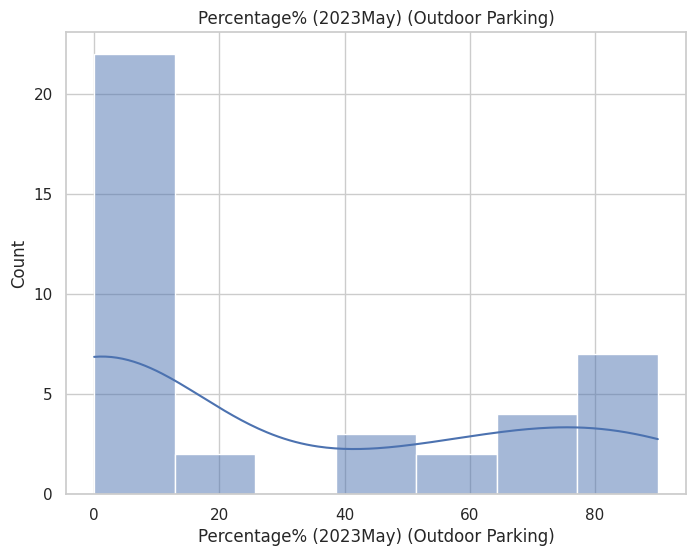

In [10]:
# Set the style of seaborn for our plots
sns.set(style="whitegrid")

# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.histplot(df_outdoor[target_column], kde=True)
plt.title(f'Percentage% ({recent_month_str}) (Outdoor Parking)')
plt.show()

In [11]:
X_outdoor = df_outdoor[feature_columns]
y = df_outdoor[target_column]

In [12]:
# Split data
X_train_outdoor, X_test_outdoor, y_train, y_test = train_test_split(X_outdoor, y, test_size=0.2, random_state=42)

# Train the model
rf_outdoor = RandomForestRegressor(random_state=42)
rf_outdoor.fit(X_train_outdoor, y_train)

RandomForestRegressor(random_state=42)

In [13]:
# Feature Importance
features_importances_outdoor = sorted(zip(rf_outdoor.feature_importances_, feature_columns), reverse=True)

# Print feature importances
for importance, name in features_importances_outdoor:
    print(f'{name}: {importance}')

Percentage% (2022Jul) (Outdoor Parking): 0.15939154174446726
Percentage% (2022Sep) (Outdoor Parking): 0.1495678867338387
Percentage% (2022Dec) (Outdoor Parking): 0.12519744243099373
Percentage% (2022Aug) (Outdoor Parking): 0.12363015595093707
Percentage% (2022Oct) (Outdoor Parking): 0.11336060089294904
Percentage% (2023Apr) (Outdoor Parking): 0.10535761319976351
Percentage% (2023Jun) (Outdoor Parking): 0.04171636094711124
Lease_Turnover_Rate% (2022Jul) (Outdoor Parking): 0.0275712926586249
Lease_Turnover_Rate% (2023Apr) (Outdoor Parking): 0.014574168110524472
Lease_Turnover_Rate% (2022Aug) (Outdoor Parking): 0.013095146951845191
Lease_Turnover_Rate% (2022Sep) (Outdoor Parking): 0.012367829276247442
Current Price (2022Sep) (Outdoor Parking): 0.009929292386459404
Market Price (2022Oct) (Outdoor Parking): 0.009873391685868054
Ending_Lease_Rate% (2023Jun) (Outdoor Parking): 0.009707258357578186
Ending Lease (2022Jul) (Outdoor Parking): 0.009524850580307229
Total Units (2023May) (Outdoor Pa

In [14]:
# Select the most important features
important_features = [name for importance, name in features_importances_outdoor if importance > 0.01]

# Prepare the data with only the most important features
X = df_outdoor[important_features]

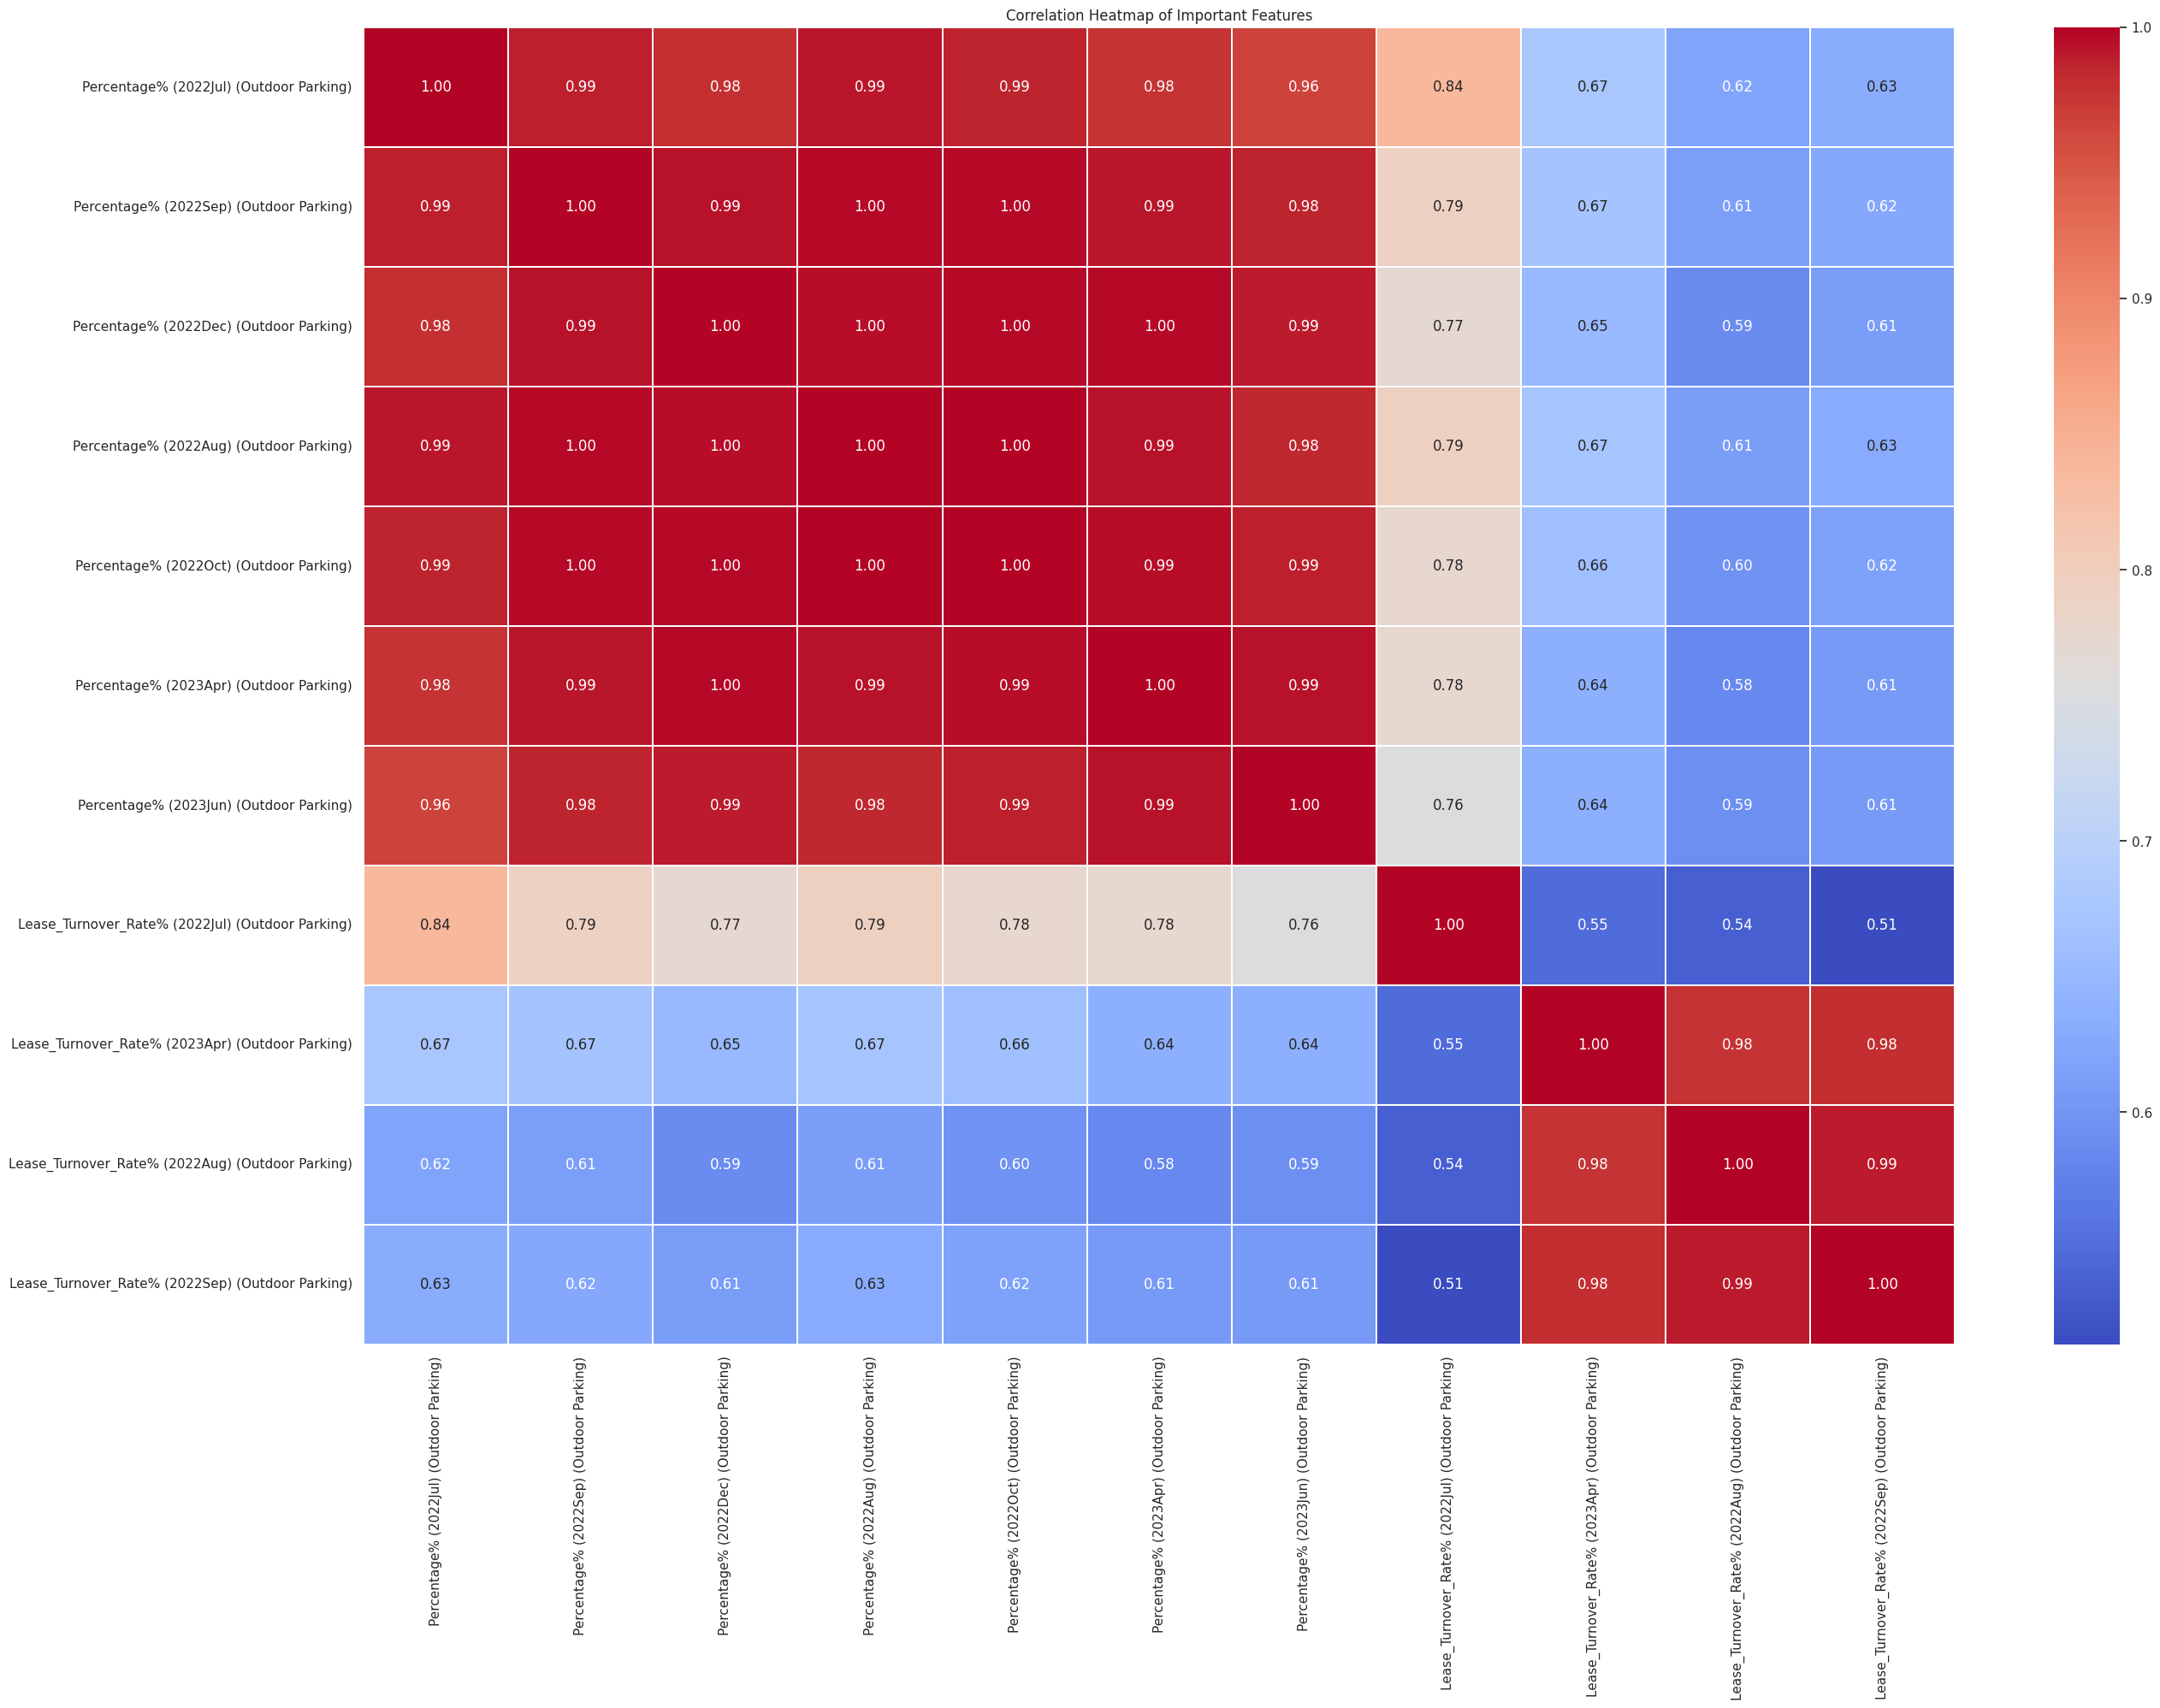

In [15]:
# Correlation heatmap of the important features
corr = df_outdoor[important_features].corr()
plt.figure(figsize=(30, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=0.1, linecolor='white', cbar=True)
plt.title('Correlation Heatmap of Important Features')
plt.show()

In [16]:
# Split the data into training and testing sets again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Initialize and train the Random Forest model again
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [18]:
# Predict the target variable for the test data
y_pred = rf.predict(X_test)

In [19]:
# Bootstrap the residuals to calculate confidence intervals
n_iterations = 1000
alpha = 0.05  # 95% confidence interval
residuals_outdoor = y_test - y_pred
lower_percentile = 100 * alpha / 2
upper_percentile = 100 * (1 - alpha / 2)
bootstrap_lower_updated = []
bootstrap_upper_updated = []

for i in range(n_iterations):
    bootstrap_residuals_updated = np.random.choice(residuals_outdoor, size=len(residuals_outdoor), replace=True)
    bootstrap_predictions_updated = y_pred + bootstrap_residuals_updated
    bootstrap_lower_updated.append(np.percentile(bootstrap_predictions_updated, lower_percentile))
    bootstrap_upper_updated.append(np.percentile(bootstrap_predictions_updated, upper_percentile))

lower_bound_updated = np.percentile(bootstrap_lower_updated, 50)
upper_bound_updated = np.percentile(bootstrap_upper_updated, 50)

lower_bound_updated, upper_bound_updated

(0.0, 77.12322250000005)

In [20]:
rmse_outdoor = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE for Outdoor Parking:', rmse_outdoor)

RMSE for Outdoor Parking: 3.2392213690175464


<ipython-input-21-3b3160d9ec7f>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='red')


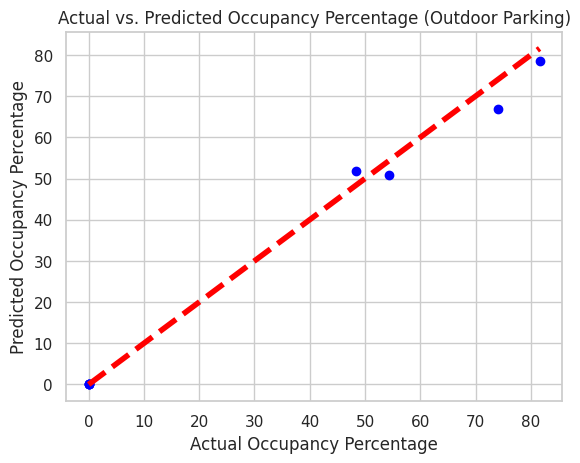

In [21]:
# Scatter plot of actual vs. predicted values
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='red')
plt.xlabel('Actual Occupancy Percentage')
plt.ylabel('Predicted Occupancy Percentage')
plt.title('Actual vs. Predicted Occupancy Percentage (Outdoor Parking)')
plt.show()

<ipython-input-22-24dc88923a3e>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='red')


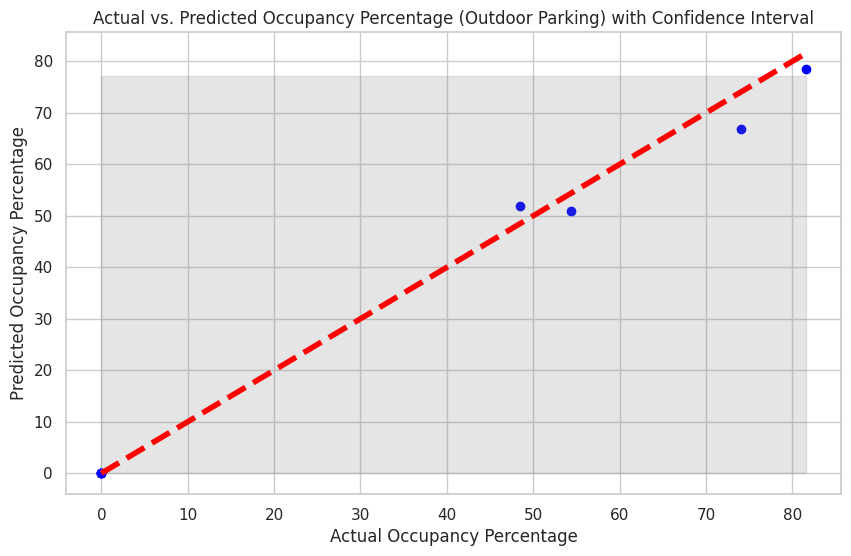

In [22]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.fill_between([y_test.min(), y_test.max()], lower_bound_updated, upper_bound_updated, color='grey', alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='red')
plt.xlabel('Actual Occupancy Percentage')
plt.ylabel('Predicted Occupancy Percentage')
plt.title('Actual vs. Predicted Occupancy Percentage (Outdoor Parking) with Confidence Interval')
plt.show()

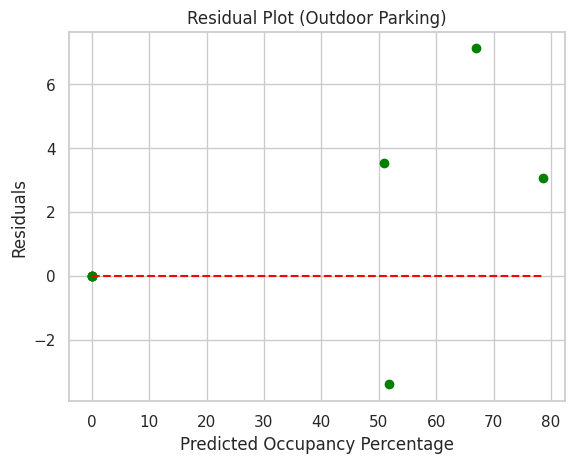

In [23]:
# Residual plot
residuals_outdoor = y_test - y_pred
plt.scatter(y_pred, residuals_outdoor, color='green')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='dashed')
plt.xlabel('Predicted Occupancy Percentage')
plt.ylabel('Residuals')
plt.title('Residual Plot (Outdoor Parking)')
plt.show()

# **Optimization**

In [24]:
# Create a new concrete model for outdoor parking optimization
model_outdoor = ConcreteModel()

# Define the decision variables
model_outdoor.price = Var(df_outdoor.index, domain=NonNegativeReals)

In [25]:
# Define the objective function
def objective_rule_outdoor(model):
    return sum(y[i] * model.price[i] for i in df_outdoor.index)
model_outdoor.objective = Objective(rule=objective_rule_outdoor, sense=maximize)

In [26]:
# Remove the existing constraints from the model
if hasattr(model_outdoor, 'price_lower_limit_constraint'):
    model_outdoor.del_component(model_outdoor.price_lower_limit_constraint)
if hasattr(model_outdoor, 'price_upper_limit_constraint'):
    model_outdoor.del_component(model_outdoor.price_upper_limit_constraint)

# Ask the user for the upper limit percentage (e.g. 1.1 for 110% of market price)
price_upper_limit = 1.1 #Can be changed

# Define the upper limit constraint for each property's price (must be <= specified percentage of market price)
market_price_column = f'Market Price ({recent_month_str}) (Outdoor Parking)'
def price_upper_limit_constraint_rule(model, i):
    return model_outdoor.price[i] <= price_upper_limit * df_outdoor.loc[i, market_price_column]
model_outdoor.price_upper_limit_constraint = Constraint(df_outdoor.index, rule=price_upper_limit_constraint_rule)

# Ask the user for the lower limit percentage (e.g. 0.9 for 90% of market price)
price_lower_limit = 0.9 # Can be changed

# Define the lower limit constraint for each property's price (must be >= specified percentage of market price)
def price_lower_limit_constraint_rule(model, i):
    return model_outdoor.price[i] >= price_lower_limit * df_outdoor.loc[i, market_price_column]
model_outdoor.price_lower_limit_constraint = Constraint(df_outdoor.index, rule=price_lower_limit_constraint_rule)

In [27]:
# Solve the model
solver = SolverFactory('glpk')
solver.solve(model_outdoor)

{'Problem': [{'Name': 'unknown', 'Lower bound': 103598.385, 'Upper bound': 103598.385, 'Number of objectives': 1, 'Number of constraints': 80, 'Number of variables': 40, 'Number of nonzeros': 80, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.004072666168212891}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [28]:
# After solving the model
optimal_prices_outdoor = [model_outdoor.price[i].value for i in df_outdoor.index]

print("Optimal prices: ", optimal_prices_outdoor)

Optimal prices:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.5, 44.0, 0.0, 0.0, 0.0, 82.5, 0.0, 0.0, 38.5, 88.0, 0.0, 0.0, 0.0, 93.5, 121.0, 82.5, 99.0, 99.0, 0.0, 99.0, 93.5, 0.0, 82.5, 77.0, 0.0, 0.0, 0.0, 82.5, 82.5, 0.0, 0.0, 93.5, 0.0, 143.0]


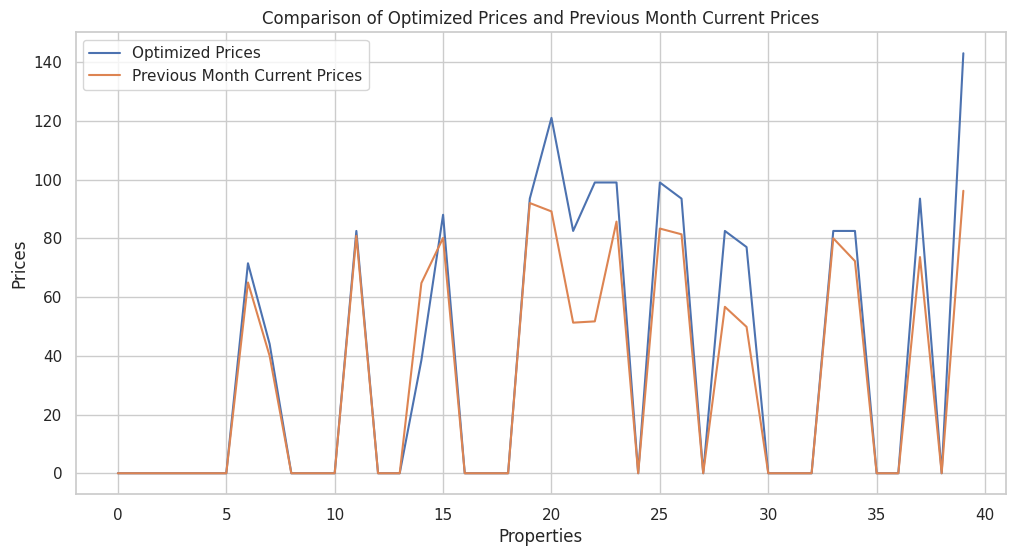

In [29]:
# Assuming you have a DataFrame `df_outdoor` and the optimized prices are stored in a list `optimal_prices`
previous_month_current_prices = df_outdoor[previous_month_column]

plt.figure(figsize=(12, 6))
plt.plot(df_outdoor.index, optimal_prices_outdoor, label='Optimized Prices')
plt.plot(df_outdoor.index, previous_month_current_prices, label='Previous Month Current Prices')
plt.xlabel('Properties')
plt.ylabel('Prices')
plt.legend()
plt.title('Comparison of Optimized Prices and Previous Month Current Prices')
plt.show()

In [30]:
# Assuming you have a DataFrame `df_outdoor` and the optimized prices are stored in a list `optimal_prices`
comparison_df = pd.DataFrame({
    'Property Code': df_outdoor['Property Code'],
    'Optimized Prices': optimal_prices_outdoor,
    'Previous Month Current Prices': previous_month_current_prices,
    'Difference': [optimal - previous for optimal, previous in zip(optimal_prices_outdoor, previous_month_current_prices)]
})

# Display the comparison table
comparison_df


,Property Code,Optimized Prices,Previous Month Current Prices,Difference
0,y31201,0.0,0.000000,0.000000
1,y31202,0.0,0.000000,0.000000
2,y31251,0.0,0.000000,0.000000
3,y31300,0.0,0.000000,0.000000
4,y31600,0.0,0.000000,0.000000
5,y31602,0.0,0.000000,0.000000
6,y40210,71.5,64.962963,6.537037
7,y40230,44.0,39.931507,4.068493
8,y40790,0.0,0.000000,0.000000
9,y40910,0.0,0.000000,0.000000


In [32]:
# Calculate the current revenue for each property based on the current prices
current_revenue = sum(df_outdoor["Current Price (2023Jun) (Outdoor Parking)"][i] *
                      df_outdoor["Total Units (2023Jun) (Outdoor Parking)"][i] *
                      (df_outdoor[target_column][i] * 0.01) for i in df_outdoor.index)
# Calculate the optimized revenue using the provided optimal prices
optimized_revenue = sum(optimal_prices_outdoor[i] *
                        df_outdoor["Total Units (2023Jun) (Outdoor Parking)"][i] *
                        (df_outdoor[target_column][i] * 0.01) for i in range(len(optimal_prices_outdoor)))

# Calculate the revenue difference
revenue_difference = optimized_revenue - current_revenue

print("Current Revenue:", current_revenue)
print("Optimized Revenue:", optimized_revenue)
print("Total Revenue Difference:", revenue_difference)

Current Revenue: 75337.10414131226
Optimized Revenue: 101096.36515000001
Total Revenue Difference: 25759.261008687754


In [33]:
from google.colab import files

In [34]:
# Export the transformed training dataset to a CSV file
#comparison_df.to_csv('Outdoor_Optimized_Prices.csv', index=False)
# Download the CSV file to your local computer
#files.download('Outdoor_Optimized_Prices.csv')